# Inference: First example

This example shows you how to perform Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc/adaptive_covariance_mcmc.html).

It follows on from [Optimisation: First example](./optimisation-first-example.ipynb)

Like in the optimisation example, we start by importing pints:

In [1]:
import pints

Next, we create a model class. 

Instead of using a real model, in this example we use the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, we choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, we can now generate some toy data:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

We can use matplotlib (or any other plotting package) to look at the data we've created:

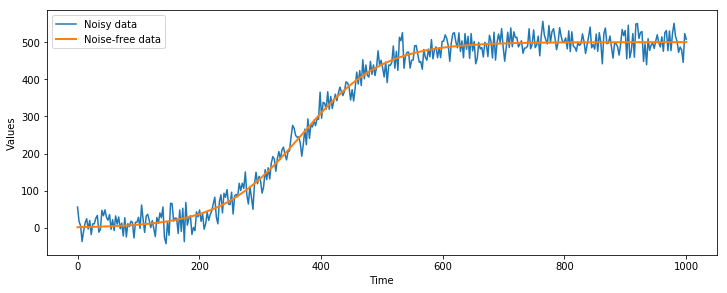

In [7]:
import matplotlib.pyplot as pl

pl.figure(figsize=(12,4.5))
pl.xlabel('Time')
pl.ylabel('Values')
pl.plot(times, values, label='Noisy data')
pl.plot(times, org_values, lw=2, label='Noise-free data')
pl.legend()
pl.show()

Now we have enough data (a model, a list of times, and a list of data) to formulate a problem:

In [8]:
problem = pints.SingleSeriesProblem(model, times, values)

We now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, we need to add a _noise model_. One way to do this is using the `UnknownNoiseLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

This noise has mean zero, and an unknown standard deviation. How can we find out the standard deviation? By inferring it along with the other parameters. This means we have added one parameter to our problem!

In [10]:
print('Original problem dimension: ' + str(problem.dimension()))

Original problem dimension: 2


In [11]:
print('New dimension: ' + str(log_likelihood.dimension()))

New dimension: 3


(This means we also have to update our vector of true parameters)

In [12]:
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

We can use this in a Bayesian inference scheme to find the quantity we're interested in:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, we now define a _prior_, indicating our initial ideas about what the parameters should be. In this example we'll assume we don't know too much except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [13]:
prior = pints.UniformPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

With this prior, we can now define the numerator of Bayes' rule -- the unnormalised log posterior, $p(\theta)p(y|\theta)$

In [14]:
log_likelihood = pints.LogPosterior(prior, log_likelihood)

And this, together with a guess at the true parameters, gives us everything we need to run an MCMC routine:

In [15]:
x0 = np.array(true_parameters) * 1.1
chain = pints.adaptive_covariance_mcmc(log_likelihood, x0)

Running adaptive covariance MCMC
Target acceptance rate: 0.25
Total number of iterations: 6000
Number of iterations before adapation: 1500
Number of iterations to discard as burn-in: 3000
Storing one sample per 1
Iteration 0 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0
Iteration 50 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0196078431373
Iteration 100 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.029702970297
Iteration 150 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0198675496689
Iteration 200 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0248756218905
Iteration 250 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0199203187251
Iteration 300 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.0232558139535
Iteration 350 of 6000
  In burn-in: True
  Adapting: False
  Acceptance rate: 0.022792022792
Iteration 400 of 6000
  In burn-in: True
  Adapting:

Iteration 4300 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.168565449895
Iteration 4350 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.169616180188
Iteration 4400 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.169961372415
Iteration 4450 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.17052347787
Iteration 4500 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.170850922017
Iteration 4550 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.171390903098
Iteration 4600 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.172136492067
Iteration 4650 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.173296065362
Iteration 4700 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.174856413529
Iteration 4750 of 6000
  In burn-in: False
  Adapting: True
  Acceptance rate: 0.175331509156
Iteration 4800 of 6000
  In burn-in: False
  Adapting: True
 

## Inspecting the results

Now we can plot samples from the resulting markov chains to approximate the distributions of the parameters:

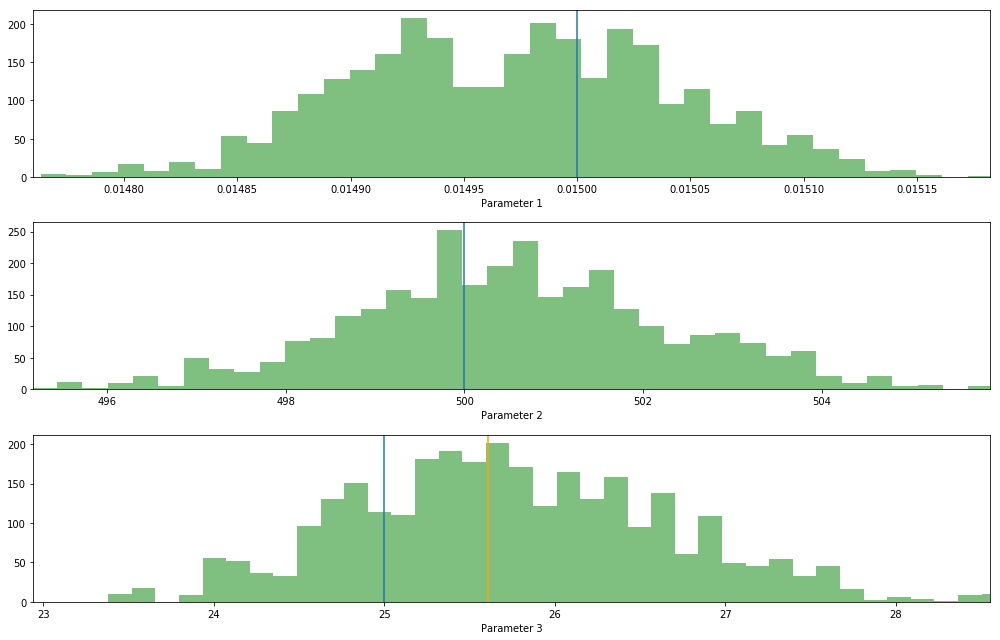

In [16]:
pl.figure(figsize=(14, 9))
for i, real in enumerate(true_parameters):
    
    # Add subplot
    pl.subplot(len(true_parameters), 1, 1+i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Show true value
    pl.axvline(real)
    
    # Show histogram of chain
    pl.hist(chain[:,i], label='p' + str(i + 1), bins=40, color='green', alpha=0.5)
    
    # Center plot around mean of chain
    mu = np.mean(chain[:,i])
    sigma = np.std(chain[:,i])
    pl.xlim(mu - 3 * sigma, mu + 3 * sigma)

# Show where the sample standard deviation of the generated noise is:
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)
pl.axvline(noise_sample_std, color='orange')

# Finalise plot
pl.tight_layout()
pl.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line).

But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.

To find out what's going on, we can plot the log-likelihood function near the true parameters:

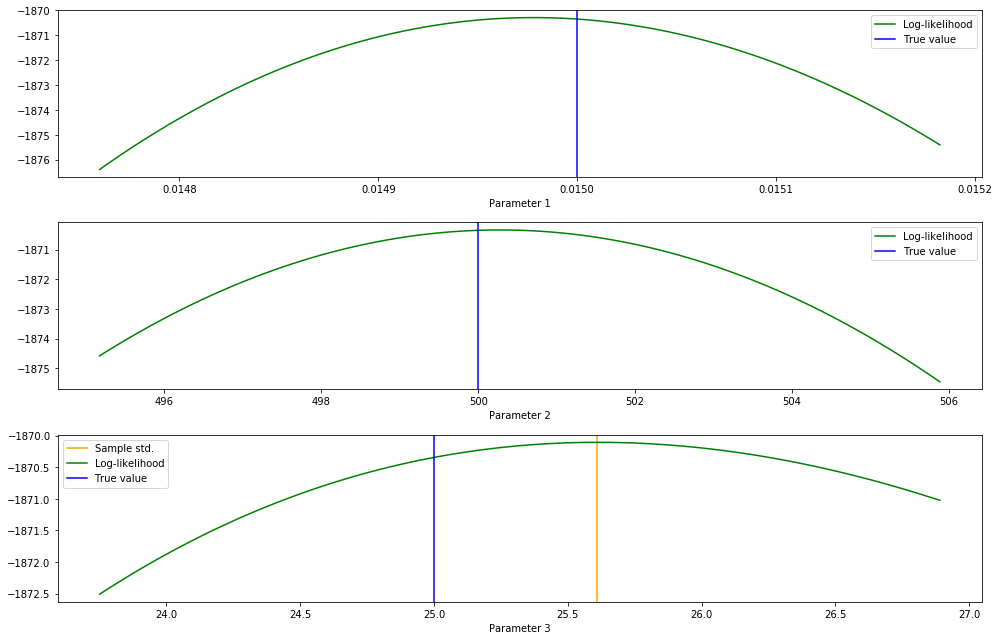

In [17]:
# Plot log-likelihood function
pl.figure(figsize=(14, 9))
for i, p in enumerate(true_parameters):
    
    # Add subplot
    pl.subplot(len(true_parameters), 1, 1 + i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Generate some x-values near the true parameter
    if i + 1 == len(true_parameters):
        # Noise plot: special case
        # First, add a line showing the sample standard deviation of the
        # generated noise
        pl.axvline(noise_sample_std, color='orange', label='Sample std.')
    
        # Next, choose a wide range of parameters so we can see the peak of the
        # log-likelihood curve
        xmin = min([p*0.95, noise_sample_std*0.95])
        xmax = max([p*1.05, noise_sample_std*1.05])
    else:
        # Choose same limits as histogram (see below)
        mu = np.mean(chain[:,i])
        sigma = np.std(chain[:,i])
        xmin = mu - 3 * sigma
        xmax = mu + 3 * sigma
    
    x = np.linspace(xmin, xmax, 100)
    
    # Calculate log-likelihood with other parameters fixed
    y = [log_likelihood(list(true_parameters[:i]) + [j]
        + list(true_parameters[1+i:])) for j in x]
    
    # Plot
    pl.plot(x, y, color='green', label='Log-likelihood')
    pl.axvline(p, color='blue', label='True value')
    pl.legend()

pl.tight_layout()
pl.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

For example, to plot the histograms shown above, we could have used the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) method. In addition to a histogram of each parameter, the pairwise plot also includes plots of pairwise parameter comparisons. These can be used to see if there are strong correlations between parameters.

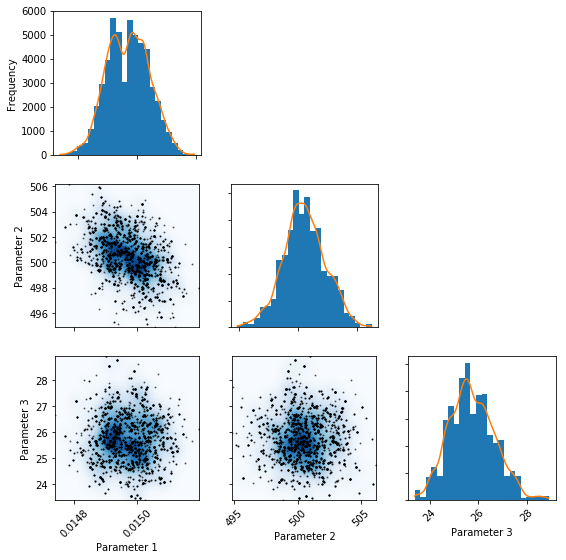

In [18]:
import pints.plot
pints.plot.pairwise(chain, kde=True)
pl.show()

Another way to inspect the results, is to take a number of samples from the chain, run new simulations using those parameters, and then compare the results with the real data (a _posterior predictive check_). This can be done using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

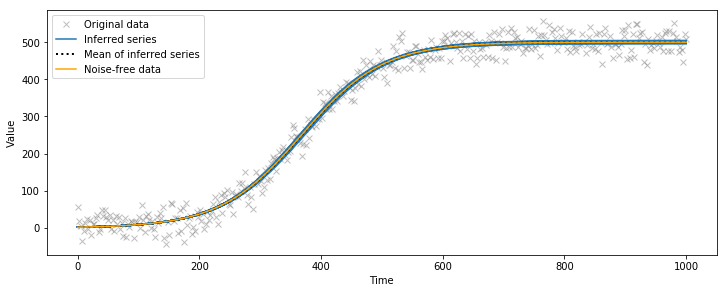

In [19]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
pl.plot(times, org_values, c='orange', label='Noise-free data')
pl.legend()
pl.show()

The [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) plot can be used to search for autocorrelation in the markov chain returned by the MCMC method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

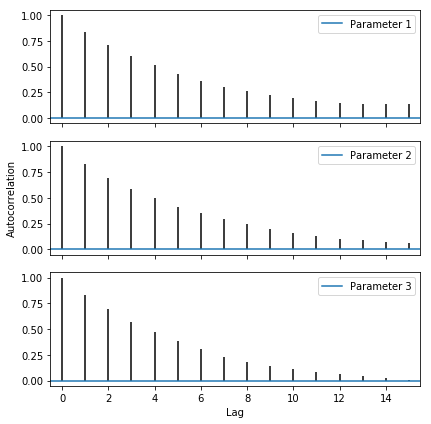

In [20]:
pints.plot.autocorrelation(chain, max_lags=15)
pl.show()

Finally, we can inspect the _traces_ of the chains as they move through parameter space, by using the [trace()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method. This is particularly useful when we've run multiple MCMC routines, so we can compare them and see if they have converged to the same point.

In [21]:
# Run two more MCMC routines
# Instead of using pints.adaptive_covariance_mcmc(), here we're using the full
# pints.AdaptiveCovarianceMCMC so we can customise the routine and disable the
# printed output.
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)
chain2 = mcmc.run()
chain3 = mcmc.run()

Then we plot the traces of the chains.

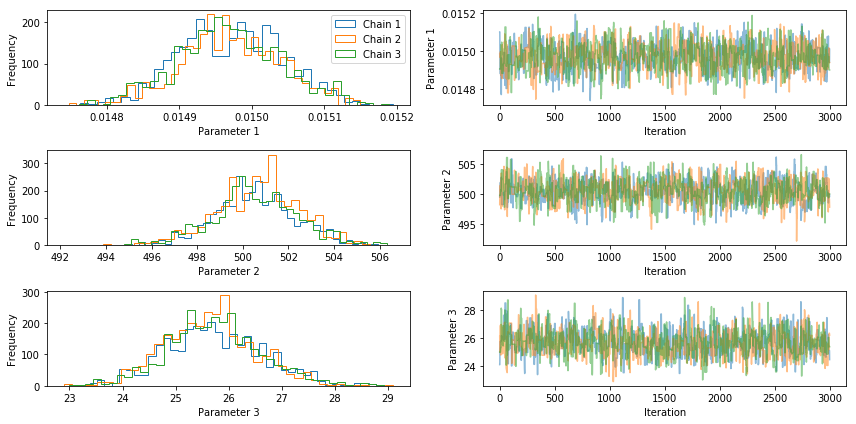

In [22]:
pints.plot.trace(chain, chain2, chain3)
pl.show()